In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(15)
torch.set_default_dtype(torch.float64)

In [27]:
def u_exact(x:torch.Tensor):
    # u_g = x**3/(0.01 + x**4)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    return u_g

def calculate_kappa(x):
    nb_zeros = torch.where(x[0:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

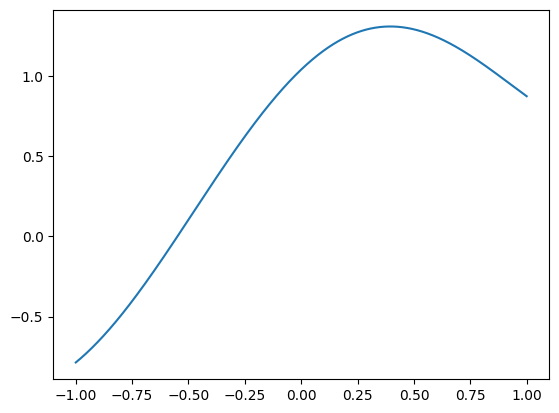

In [28]:
nb_training_points = 1501
x_train = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1).to(device)
u_train = u_exact(x_train)

low_bound_xtrain, up_bound_xtrain = x_train.min(), x_train.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1).to(device)
u_eval = u_exact(x_eval)
plt.plot(x_eval.cpu(), u_eval.cpu(), label='Exact solution')

In [ ]:
class SinActivation(torch.nn.Module):
    def __init__(self) -> None:
        super(SinActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x)
    
class FullyConnectedNN(torch.nn.Module):
    def __init__(self, x_train, u_train, layers, kappa, low_bound_xtrain, up_bound_xtrain, actv=0) -> None:
        super(FullyConnectedNN, self).__init__()

        assert isinstance(x_train, torch.cuda.DoubleTensor)
        self.u_scale = torch.sqrt(torch.mean(torch.abs(u_train**2)))
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.lb, self.up = low_bound_xtrain, up_bound_xtrain
        self.n_layers = len(layers)

        self.kappa = kappa
        self.first_activation = [torch.nn.Tanh(), SinActivation()][actv]
        self.activation = torch.nn.Tanh()

        self.weights, self.biases = self._initialize_weights(layers)

    def _initialize_weights(self, layers):
        weights, biases = [], []
        for i in range(len(layers)-1):
            W = torch.nn.Parameter(self._weight_matrix(size_in=layers[i], size_out=layers[i+1]))
            b = torch.nn.Parameter(torch.zeros(layers[i+1], 1))
            weights.append(W)
            biases.append(b)
        return torch.nn.ParameterList(weights), torch.nn.ParameterList(biases)
    
    def _weight_matrix(self, size_in, size_out):
        std = np.sqrt(2/(size_in + size_out))
        return torch.nn.init.trunc_normal_(torch.empty(size_in, size_out), std=std)
    
    def forward(self, x):
        weights = self.weights
        biases = self.biases
        x_normalized = 2*(x - self.lb)/(self.up - self.lb) - 1

        W, b = weights[0], biases[0]
        x_forwarded = self.first_activation(self.kappa*(x_normalized @ W) + b.T)

        for i in range(1, self.n_layers-2):
            W, b = weights[i], biases[i]
            x_forwarded = self.activation(self.kappa*(x_forwarded @ W) + b.T)

        W, b = weights[-1], biases[-1]
        u_theta = x_forwarded @ W + b.T
        return u_theta
    
    def train(self, n_iter):
        criterion = torch.nn.MSELoss()
        model_optimizer = torch.optim.Adam(self.parameters(), lr=0.0005)

        for iter_i in range(n_iter): 
            model_optimizer.zero_grad()

            u_pred = self.forward(self.x_train)
            loss = criterion(self.u_train, u_pred) 
            
            loss.backward(retain_graph=True)
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iter {iter_i}, Loss: {(loss*self.loss_scale).item()}')

    def predict(self, x):
        return self.u_scale*self.forward(x)

In [30]:
model1 = FullyConnectedNN(x_train=x_train, u_train=u_train, layers=[1, 20, 20, 20, 1], kappa=1, low_bound_xtrain=low_bound_xtrain, up_bound_xtrain=up_bound_xtrain, actv=0).to(device)
model1.train(10000)
u_pred = model1.predict(x_eval)

Iter 0, Loss: 1.0355942199682202
Iter 100, Loss: 0.08069601453076812
Iter 200, Loss: 0.05712446460879522
Iter 300, Loss: 0.029296350577798627
Iter 400, Loss: 0.012479454265966897
Iter 500, Loss: 0.007373327505757552
Iter 600, Loss: 0.006163634136170794
Iter 700, Loss: 0.005532668809792241
Iter 800, Loss: 0.004979673307257855
Iter 900, Loss: 0.004468633645113125
Iter 1000, Loss: 0.003998020755322688
Iter 1100, Loss: 0.003566383168538391
Iter 1200, Loss: 0.00317082679634446
Iter 1300, Loss: 0.0028076780194233575
Iter 1400, Loss: 0.0024732527461340734
Iter 1500, Loss: 0.0021643995820055627
Iter 1600, Loss: 0.0018787631628851874
Iter 1700, Loss: 0.001614825415219546
Iter 1800, Loss: 0.0013718126116083898
Iter 1900, Loss: 0.001149539649927544
Iter 2000, Loss: 0.0009482295903026058
Iter 2100, Loss: 0.0007683162023394277
Iter 2200, Loss: 0.0006102233600397793
Iter 2300, Loss: 0.00047412522671926813
Iter 2400, Loss: 0.0003597210008935992
Iter 2500, Loss: 0.00026608414608441744
Iter 2600, Loss:

In [31]:
error_1 = u_train - model1.predict(x_train)
kappa2 = calculate_kappa(error_1)

print(f'Le coefficient kappa2 vaut: {kappa2}')

model2 = FullyConnectedNN(x_train=x_train, u_train=error_1, layers=[1, 20, 20, 20, 1], kappa=kappa2, low_bound_xtrain=low_bound_xtrain, up_bound_xtrain=up_bound_xtrain, actv=1).to(device)
model2.train(25000)
u_pred2 = model2.predict(x_eval)
u_p = u_pred + u_pred2

Le coefficient kappa2 vaut: 24
Iter 0, Loss: 1.6944374455288296
Iter 100, Loss: 0.43979257919824266
Iter 200, Loss: 0.18933140311000787
Iter 300, Loss: 0.10936955343159181
Iter 400, Loss: 0.07532281330508765
Iter 500, Loss: 0.05686658324419079
Iter 600, Loss: 0.04532111857981246
Iter 700, Loss: 0.03464957369116306
Iter 800, Loss: 0.02853986374420757
Iter 900, Loss: 0.023856674195382517
Iter 1000, Loss: 0.020287087199771084
Iter 1100, Loss: 0.017403680454745468
Iter 1200, Loss: 0.014599756388918335
Iter 1300, Loss: 0.012985618419874926
Iter 1400, Loss: 0.01047469149766514
Iter 1500, Loss: 0.00868029179319351
Iter 1600, Loss: 0.006642451953877568
Iter 1700, Loss: 0.005782615831072981
Iter 1800, Loss: 0.0054313154666931875
Iter 1900, Loss: 0.005047892182872063
Iter 2000, Loss: 0.004632553335386533
Iter 2100, Loss: 0.004417894059206303
Iter 2200, Loss: 0.00404872014407277
Iter 2300, Loss: 0.003964617597889757
Iter 2400, Loss: 0.0038500942710641604
Iter 2500, Loss: 0.003499500352573244
Iter

In [32]:
x_train2 = torch.linspace(-1.02, 1.02, 4801).reshape(-1,1).to(device)
u_train2 = u_exact(x_train2)
error_2 = u_train2 - model1.predict(x_train2).detach() - model2.predict(x_train2).detach()
kappa3 = calculate_kappa(error_2)

print(f'Le coefficient kappa3 vaut: {kappa3}')

model3 = FullyConnectedNN(x_train=x_train2, u_train=error_2, layers=[1, 30, 30, 30, 1], kappa=kappa3, low_bound_xtrain=low_bound_xtrain, up_bound_xtrain=up_bound_xtrain, actv=1).to(device)
model3.train(10000)
u_pred3 = model3.predict(x_eval)
u_p2 = u_pred + u_pred2 + u_pred3

Le coefficient kappa3 vaut: 840
Iter 0, Loss: 3.1443168356116433
Iter 100, Loss: 2.0952837075901454
Iter 200, Loss: 1.7107604830542198
Iter 300, Loss: 1.5149103678567897
Iter 400, Loss: 1.3915458829159149
Iter 500, Loss: 1.3148791553679424
Iter 600, Loss: 1.2469415909868267
Iter 700, Loss: 1.2048535356055454
Iter 800, Loss: 1.1725316885149304
Iter 900, Loss: 1.1614722385758165
Iter 1000, Loss: 1.0915401755605418
Iter 1100, Loss: 1.1010625798679867
Iter 1200, Loss: 1.0413091039433908
Iter 1300, Loss: 1.03329935240942
Iter 1400, Loss: 1.0447347419609887
Iter 1500, Loss: 1.0544115332883721
Iter 1600, Loss: 1.0116452681987191
Iter 1700, Loss: 1.0136311708842476
Iter 1800, Loss: 1.0054541090559252
Iter 1900, Loss: 1.011785889878226
Iter 2000, Loss: 1.0012429924208672
Iter 2100, Loss: 0.9879963096834244
Iter 2200, Loss: 0.9933285434370704
Iter 2300, Loss: 1.0035476854336358
Iter 2400, Loss: 0.9919995896385377
Iter 2500, Loss: 0.9922616757240503
Iter 2600, Loss: 0.9910124608487973
Iter 2700, 

Text(0.5, 1.0, 'Residue order 2')

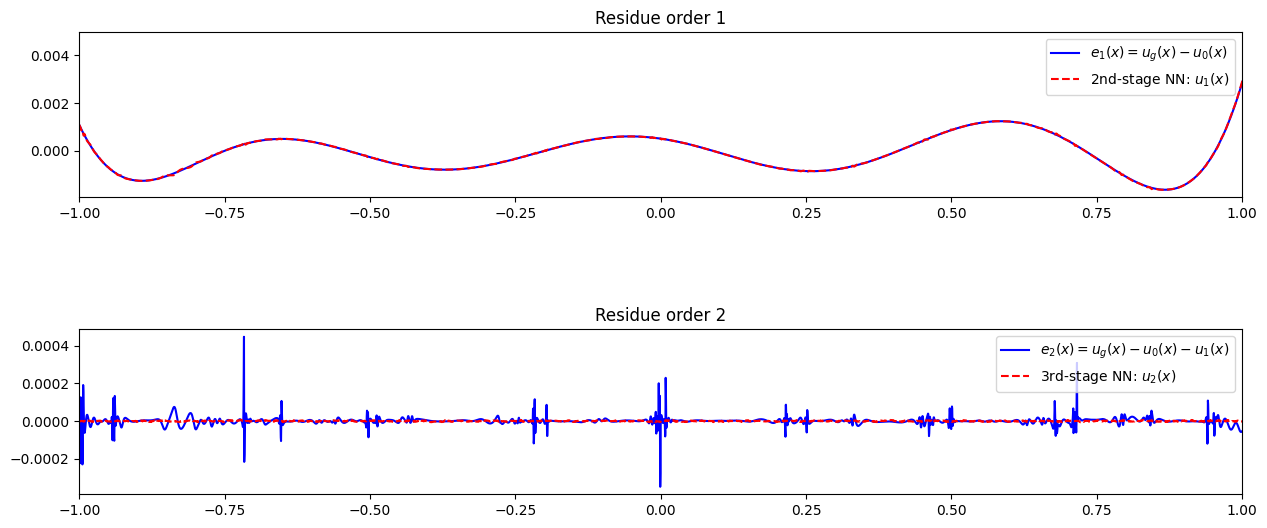

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
fig.subplots_adjust(hspace=0.8)

axes[0].plot(x_train.cpu(), error_1.cpu().detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[0].plot(x_train.cpu(), model2.predict(x_train).cpu().detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[0].set_xlim(-1, 1)
axes[0].legend()
axes[0].set_title('Residue order 1')

axes[1].plot(x_train2.cpu(), error_2.cpu().detach(), 'b-', label=r'$e_2(x) = u_g(x) - u_0(x) - u_1(x)$')
axes[1].plot(x_train2.cpu(), model3.predict(x_train2).cpu().detach(), 'r--', label=r'3rd-stage NN: $u_2(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 2')

In [34]:
error_u = np.linalg.norm(u_eval.cpu() - u_pred.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u2 = np.linalg.norm(u_eval.cpu() - u_p.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u3 = np.linalg.norm(u_eval.cpu() - u_p2.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)

print(f'Error of order 1: {error_u}')
print(f'Error of order 2: {error_u2}')
print(f'Error of order 3: {error_u3}')

Error of order 1: 0.0008110630724097695
Error of order 2: 2.3426857672180458e-05
Error of order 3: 2.34068435332523e-05
